In [1]:
import pandas as pd
import sys
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sys.path.insert(0, '../../')

# Read in data

In [4]:
imbal_train_df = pd.read_csv('../../data/imbalance_data/cleaned_08-01-2020_22_15_47 - 08-01-2020_22_15_47_all_data.csv')

In [17]:
imbal_train_df = imbal_train_df.loc[:, imbal_train_df.columns != 'close']

In [18]:
imbal_train_df.shape

(13540, 21)

# Split into x and y

In [19]:
imbal_train_X = imbal_train_df.loc[:, imbal_train_df.columns != 'pct_move_snapshot_to_close']
imbal_train_y = imbal_train_df.loc[:, imbal_train_df.columns == 'pct_move_snapshot_to_close']

# train

In [20]:
mae = []
mae_above_threshold = []
mae_positive_predictions = []
mae_negative_predictions= [] 
n_correct_signs=[]

n_correct_sign_and_more_extreme_predictions = []
n_correct_sign_and_threshold = []
total_delta_close_last = []
len_correct=[]
threshold = .10
cv = 120
position_size=5000

for i in range(cv):
    if i % 20 == 0:
        print(i/cv)
    lr =LinearRegression()
    X_train, X_test, y_train, y_test  = train_test_split(imbal_train_X, imbal_train_y, test_size=0.15) # RandomForestRegressor(n_jobs=-1) #ain, X_test, y_train, y_test  = train_test_split(imbal_train_X, imbal_train_y, test_size=0.10)
#     p_and_l_test_df = X_test.join(p_and_l_df)
    
    
    lr.fit(X_train, y_train )

    test_predictions = lr.predict(X_test)
    mae.append(mean_absolute_error(y_test, test_predictions) )

    # what about more extreme predicitons, above threshold
    threshold_mask = np.abs(test_predictions) > threshold
    threshold_test_predictions = test_predictions[threshold_mask]
    threshold_y_test = y_test[threshold_mask]
    mae_above_threshold.append(mean_absolute_error(threshold_y_test, threshold_test_predictions))

    # are we better at positive or negative predictions?
    positive_mask = np.sign(test_predictions) == 1
    positive_predictions = test_predictions[positive_mask]
    positive_y_test = y_test[positive_mask]
    mae_positive_predictions.append(mean_absolute_error(positive_y_test, positive_predictions))

    negative_predictions = test_predictions[np.sign(test_predictions) == -1]
    negative_y_test = y_test[np.sign(test_predictions) == -1]
    mae_negative_predictions.append(mean_absolute_error(negative_y_test, negative_predictions))

    # sign of prediction and more extreme signs
    len_correct.append(len(y_test))
    n_sign_and_extreme = []
    n_sign = []
    n_sign_and_threshold = []
    delta_close_last_array = []
    
    prediction_index = 0
    for pred_, true_ in zip(test_predictions, np.array(y_test).ravel()):

        if (np.sign(pred_) == np.sign(true_) ) and (np.abs(true_) > np.abs(pred_)):
            n_sign_and_extreme.append(1)
        if (np.sign(pred_) == np.sign(true_) ) :
            n_sign.append(1)
        if (np.abs(pred_) > threshold) and (np.sign(pred_) == np.sign(true_) ) : 
            n_sign_and_threshold.append(1)
            
#         if (np.abs(pred_) > threshold): ## get into a position here
#             stock_direction_pred = np.sign(pred_) # direction stock is going to move
            
#             # calculate P & l
#             last_price =  p_and_l_test_df.iloc[prediction_index, :]['lastprice_unnormalized']
            
#             close_price = p_and_l_test_df.iloc[prediction_index, :]['close']
            
#             if stock_direction_pred > 0: # going up
#                 delta_close_last = close_price - last_price
            
#             else: # going down
#                 delta_close_last = last_price - close_price 
            
#             delta_close_last_array.append(delta_close_last)
                
            
        prediction_index += 1
            
            
            

            
        
    n_correct_sign_and_more_extreme_predictions.append(np.sum(n_sign_and_extreme))
    n_correct_signs.append(np.sum(n_sign))
    n_correct_sign_and_threshold.append(np.sum(n_sign_and_threshold))
    total_delta_close_last.append(np.sum(delta_close_last_array))



0.0
0.16666666666666666
0.3333333333333333
0.5
0.6666666666666666
0.8333333333333334


In [21]:
print(f"median mae for negative predictions = {np.median(mae_negative_predictions):.2%}")
print(f"median mae for positive predictions = {np.median(mae_positive_predictions):.2%}") # slightly better as positive predictions
print(f"median MAE with threshold predictions = {np.median(mae_above_threshold):.2%}")
print(f"median MAE with all data is {np.median(mae):.2%}")
print(f"pct of the time we guess the corect sign (up or down) all data is {np.sum(n_correct_signs)/np.sum(len_correct):.2%}")
print(f"pct of the time we guess the corect sign (up or down) all data and the true data is more extreme {np.sum(n_correct_sign_and_more_extreme_predictions)/np.sum(len_correct):.2%}")
print(f"pct of the time we guess the corect sign (up or down) and the prediction is more extreme than our threshold \
    of {threshold} =  {np.sum(n_correct_sign_and_threshold)/np.sum(len_correct):.2%}")


median mae for negative predictions = 30.71%
median mae for positive predictions = 26.45%
median MAE with threshold predictions = 32.93%
median MAE with all data is 29.48%
pct of the time we guess the corect sign (up or down) all data is 61.28%
pct of the time we guess the corect sign (up or down) all data and the true data is more extreme 40.50%
pct of the time we guess the corect sign (up or down) and the prediction is more extreme than our threshold     of 0.1 =  38.75%


# Coefficients

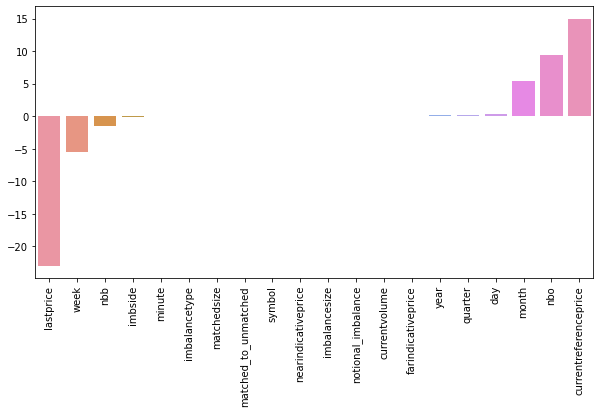

In [22]:
plt.figure(figsize=(10,5))
sns.barplot(x = X_train.columns[np.argsort(lr.coef_).ravel()], y = lr.coef_.ravel()[np.argsort(lr.coef_).ravel()])
plt.xticks(rotation=90) ;